In [185]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV
from imblearn.over_sampling import SMOTE
from itertools import combinations
from itertools import product
from sklearn.metrics import mean_squared_error

In [186]:
data = pd.read_csv('clean_ted_ratings.csv', encoding='latin1')
data.head()

,comments,duration,film_date,languages,main_speaker,num_speaker,published_date,speaker_occupation,title,views,...,Inspiring,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious,Title_Length,Number_Question_marks
0,4553,1164,1140825600,60,Ken Robinson,1,1151367060,Author/educator,Do schools kill creativity?,47227110,...,0.265573,0.004124,0.003197,0.112744,0.047299,0.114054,0.012509,0.002227,4,0
1,265,977,1140825600,43,Al Gore,1,1151367060,Climate advocate,Averting the climate crisis,3200520,...,0.140668,0.038488,0.087875,0.044959,0.039510,0.091281,0.069142,0.044619,4,0
2,124,1286,1140739200,26,David Pogue,1,1151367060,Technology columnist,Simplicity sells,1636292,...,0.081445,0.027620,0.036827,0.058782,0.019122,0.081445,0.051700,0.050283,2,0
3,200,1116,1140912000,35,Majora Carter,1,1151367060,Activist for environmental justice,Greening the ghetto,1697550,...,0.287017,0.014217,0.009657,0.035408,0.061695,0.123391,0.022800,0.009388,3,0
4,593,1190,1140566400,48,Hans Rosling,1,1151440680,Global health expert; data visionary,The best stats you've ever seen,12005869,...,0.112920,0.004294,0.002615,0.179781,0.145824,0.099219,0.009680,0.002381,6,0


In [187]:
data = data.drop('main_speaker', axis = 1)
data = data.drop('speaker_occupation', axis=1)
data = data.drop('title', axis=1)

In [188]:
def get_ranking(views):
    if views > 10000000: return 'rank1'
    elif 5000000 < views <= 10000000: return 'rank2'
    elif 1000000 < views <= 5000000: return 'rank3'
    else: return 'rank4'
    
data['rank'] = data['views'].apply(get_ranking)

In [189]:
data.head()

,comments,duration,film_date,languages,num_speaker,published_date,views,Beautiful,Confusing,Courageous,...,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious,Title_Length,Number_Question_marks,rank
0,4553,1164,1140825600,60,1,1151367060,47227110,0.048727,0.002579,0.034662,...,0.004124,0.003197,0.112744,0.047299,0.114054,0.012509,0.002227,4,0,rank1
1,265,977,1140825600,43,1,1151367060,3200520,0.019755,0.021117,0.047343,...,0.038488,0.087875,0.044959,0.039510,0.091281,0.069142,0.044619,4,0,rank3
2,124,1286,1140739200,26,1,1151367060,1636292,0.021246,0.009561,0.015935,...,0.027620,0.036827,0.058782,0.019122,0.081445,0.051700,0.050283,2,0,rank3
3,200,1116,1140912000,35,1,1151367060,1697550,0.078058,0.008584,0.203863,...,0.014217,0.009657,0.035408,0.061695,0.123391,0.022800,0.009388,3,0,rank3
4,593,1190,1140566400,48,1,1151440680,12005869,0.036768,0.002810,0.012412,...,0.004294,0.002615,0.179781,0.145824,0.099219,0.009680,0.002381,6,0,rank1


In [190]:
y = data['views']
X = data.drop('views', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Check Levels of Views in the dataset

In [191]:
X_train['rank'].value_counts()

rank3    1140
rank4     822
rank2      50
rank1      28
Name: rank, dtype: int64

In [192]:
X_test['rank'].value_counts()

rank3    264
rank4    225
rank2     15
rank1      6
Name: rank, dtype: int64

In [193]:
rank3_train, rank4_train, rank2_train, rank1_train = X_train['rank'].value_counts()
rank3_test, rank4_test, rank2_test, rank1_test = X_test['rank'].value_counts()

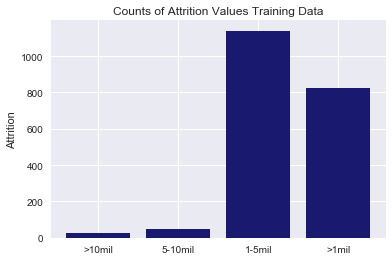

In [194]:
x = np.arange(4)
tr_vals = [rank1_train, rank2_train, rank3_train, rank4_train] #1 is the biggest, 4 is the smallest views
test_vals = [rank1_test, rank2_test, rank3_test, rank4_test]

plt.bar(x, tr_vals,color = 'midnightblue');
plt.xticks(x, ('>10mil', '5-10mil', '1-5mil', '>1mil'));
plt.ylabel('Attrition');
plt.title('Counts of Attrition Values Training Data');

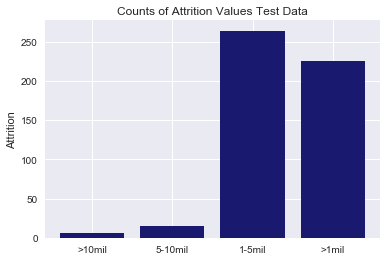

In [195]:
plt.bar(x, test_vals,color = 'midnightblue');
plt.xticks(x, ('>10mil', '5-10mil', '1-5mil', '>1mil'));
plt.ylabel('Attrition');
plt.title('Counts of Attrition Values Test Data');

### Balance Groups of Views in the Dataset

In [196]:
y = data['rank']
X = data.drop('rank', axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [197]:
sm = SMOTE(random_state=0)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

In [198]:
features_names = X_train.columns.values
X_train_res_df = pd.DataFrame(X_train_res)
X_train_res_df.columns = np.ndarray.tolist(features_names)

In [199]:
X_train_res_df.head()

,comments,duration,film_date,languages,num_speaker,published_date,views,Beautiful,Confusing,Courageous,...,Inspiring,Longwinded,Unconvincing,Fascinating,Jaw-dropping,Persuasive,OK,Obnoxious,Title_Length,Number_Question_marks
0,124.0,1016.0,1.379635e+09,26.0,1.0,1.381764e+09,1041732.0,0.016507,0.007819,0.018245,...,0.211121,0.010426,0.016507,0.079930,0.013032,0.236316,0.035621,0.008688,3.0,1.0
1,168.0,684.0,1.330474e+09,40.0,1.0,1.333984e+09,3055565.0,0.315495,0.000532,0.046592,...,0.282748,0.003461,0.004526,0.111821,0.023695,0.008253,0.013578,0.005591,4.0,0.0
2,202.0,1112.0,1.340669e+09,24.0,1.0,1.348585e+09,1245095.0,0.007715,0.005935,0.027300,...,0.228487,0.007715,0.003561,0.116914,0.042136,0.207122,0.012463,0.002374,8.0,1.0
3,15.0,467.0,1.481587e+09,16.0,1.0,1.500649e+09,1026708.0,0.100000,0.000000,0.125926,...,0.270370,0.000000,0.000000,0.055556,0.018519,0.074074,0.011111,0.000000,6.0,0.0
4,59.0,915.0,1.455581e+09,29.0,1.0,1.466694e+09,4235594.0,0.053057,0.003659,0.022717,...,0.125781,0.005336,0.004879,0.187224,0.011892,0.047111,0.032627,0.002592,8.0,1.0


In [200]:
rank1 = np.count_nonzero(y_train_res =='rank1')
rank2 = np.count_nonzero(y_train_res =='rank2')
rank3 = np.count_nonzero(y_train_res=='rank3')
rank4 = np.count_nonzero(y_train_res=='rank4')

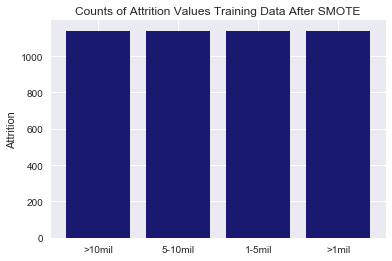

In [201]:
x = np.arange(4)
tr_vals = [rank1, rank2, rank3, rank4] #1 is the biggest, 4 is the smallest views

plt.bar(x, tr_vals,color = 'midnightblue');
plt.xticks(x, ('>10mil', '5-10mil', '1-5mil', '>1mil'));
plt.ylabel('Attrition');
plt.title('Counts of Attrition Values Training Data After SMOTE');

In [202]:
#save as a csv
np.savetxt('SMOTE_dataset.csv', X_train_res_df, delimiter=",")
np.savetxt('SMOTE_test_data.csv', X_test, delimiter=',')

## Back to Random Forest

In [203]:
y_train = X_train_res_df['views']
X_train = X_train_res_df.drop('views', axis=1)
y_test = X_test['views']
X_test = X_test.drop('views', axis=1)

There is now a problem with using gridsearch- when we do k-fold cross validation we need to have the training sets be oversampled and the validation sets not be oversampled- with gridsearch we have all folds that are oversampled...

### Cross Validation for the RF Parameters

In [229]:
y = data['rank']
X = data.drop('rank', axis=1)
X_train_cv, X_test_cv, y_train_cv, y_test_cv = train_test_split(X, y, test_size=0.2, random_state=42)
#piece together X_train and y_train to one training set, then use this for the CV
y_train_cv = y_train_cv.to_frame()
CV_data = pd.merge(X_train_cv, y_train_cv, left_index=True, right_index=True, how = 'left')

In [230]:
indices = [1,2,3,4,5]
dfList = np.array_split(CV_data, 5)
CVgrid = []
n_estimators = [50, 100, 200]; max_depth = [7,10,13,15]
c = list(product(n_estimators, max_depth))

for choices in c:
    for combo in combinations(indices, 4):
        #append and then oversample
        comb_folds = pd.concat([dfList[combo[0]-1], dfList[combo[1]-1], 
                                dfList[combo[2]-1], dfList[combo[3]-1]])
        remain_ind = 15 - sum(combo) #isolate the remaining index 
        remain = dfList[remain_ind-1].drop('rank', axis=1)
        
        #oversample the comb_folds
        y = comb_folds['rank']
        X = comb_folds.drop('rank', axis = 1)
        sm = SMOTE(random_state=0)
        X_res, y_res = sm.fit_sample(X, y)
        features_names = X.columns.values
        X_res_df = pd.DataFrame(X_res)
        X_res_df.columns = np.ndarray.tolist(features_names)

        #split into the correct X and y
        y_train_correct = X_res_df['views']
        X_train_correct = X_res_df.drop('views', axis=1)
        y_test_correct = remain['views']
        X_test_correct = remain.drop('views', axis=1)
    
        mse = []
        #choices[0] is the n_estimators, choices[1] is max_depth
        regr = RandomForestRegressor(n_estimators=choices[0], max_depth=choices[1], random_state=42)
        regr.fit(X_train_correct, y_train_correct)
        y_pred = regr.predict(X_test_correct)
        MSE = mean_squared_error(y_test_correct, y_pred)
        mse.append(MSE)
      
    mse_info = {}
    avg_mse = sum(mse)/len(mse)
    mse_info['MSE'] = avg_mse
    mse_info['N_trees'] = choices[0]
    mse_info['Max_depth'] = choices[1]
    print('model with %s trees and %s depth has MSE of %s' %(choices[0], choices[1], avg_mse))
    CVgrid.append(mse_info)

model with 50 trees and 7 depth has MSE of 5681765691202.119
model with 50 trees and 10 depth has MSE of 5434207004631.191
model with 50 trees and 13 depth has MSE of 5339590480187.852
model with 50 trees and 15 depth has MSE of 5505430431307.459
model with 100 trees and 7 depth has MSE of 5779989700428.749
model with 100 trees and 10 depth has MSE of 5438013127987.04
model with 100 trees and 13 depth has MSE of 5422868033401.497
model with 100 trees and 15 depth has MSE of 5493646122003.906
model with 200 trees and 7 depth has MSE of 6010887569082.1045
model with 200 trees and 10 depth has MSE of 5619099274328.853
model with 200 trees and 13 depth has MSE of 5621321396525.034
model with 200 trees and 15 depth has MSE of 5636188392858.37


In [231]:
#make into a dataframe and get the best parameters
#need to make it a list of dictionaries instead
CVgrid

[{'MSE': 5681765691202.119, 'Max_depth': 7, 'N_trees': 50},
 {'MSE': 5434207004631.191, 'Max_depth': 10, 'N_trees': 50},
 {'MSE': 5339590480187.852, 'Max_depth': 13, 'N_trees': 50},
 {'MSE': 5505430431307.459, 'Max_depth': 15, 'N_trees': 50},
 {'MSE': 5779989700428.749, 'Max_depth': 7, 'N_trees': 100},
 {'MSE': 5438013127987.04, 'Max_depth': 10, 'N_trees': 100},
 {'MSE': 5422868033401.497, 'Max_depth': 13, 'N_trees': 100},
 {'MSE': 5493646122003.906, 'Max_depth': 15, 'N_trees': 100},
 {'MSE': 6010887569082.1045, 'Max_depth': 7, 'N_trees': 200},
 {'MSE': 5619099274328.853, 'Max_depth': 10, 'N_trees': 200},
 {'MSE': 5621321396525.034, 'Max_depth': 13, 'N_trees': 200},
 {'MSE': 5636188392858.37, 'Max_depth': 15, 'N_trees': 200}]

In [232]:
CVresults = pd.DataFrame(CVgrid)
CVresults.head()

,MSE,Max_depth,N_trees
0,5.681766e+12,7,50
1,5.434207e+12,10,50
2,5.339590e+12,13,50
3,5.505430e+12,15,50
4,5.779990e+12,7,100


In [233]:
#find the minimum MSE
CVresults.loc[CVresults['MSE'] == CVresults['MSE'].min()]

,MSE,Max_depth,N_trees
2,5.339590e+12,13,50


In [209]:
regr = RandomForestRegressor(n_estimators=50, max_depth=13, random_state=42)
regr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=13,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [212]:
X_train.shape

(4560, 22)

In [214]:
X_test.shape

(510, 22)

In [215]:
y_test.shape

(510,)

22


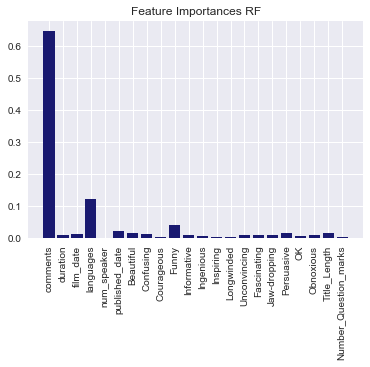

In [217]:
labels = X_train.columns
x_axis = np.arange(22)
impo = regr.feature_importances_

plt.bar(x_axis, impo, align='center', color='midnightblue');
plt.xticks(x_axis, labels, rotation='vertical');
plt.title('Feature Importances RF');
print(regr.n_features_)

In [218]:
y_pred = regr.predict(X_test)
mse_random_forest_all = mean_squared_error(y_test, y_pred)

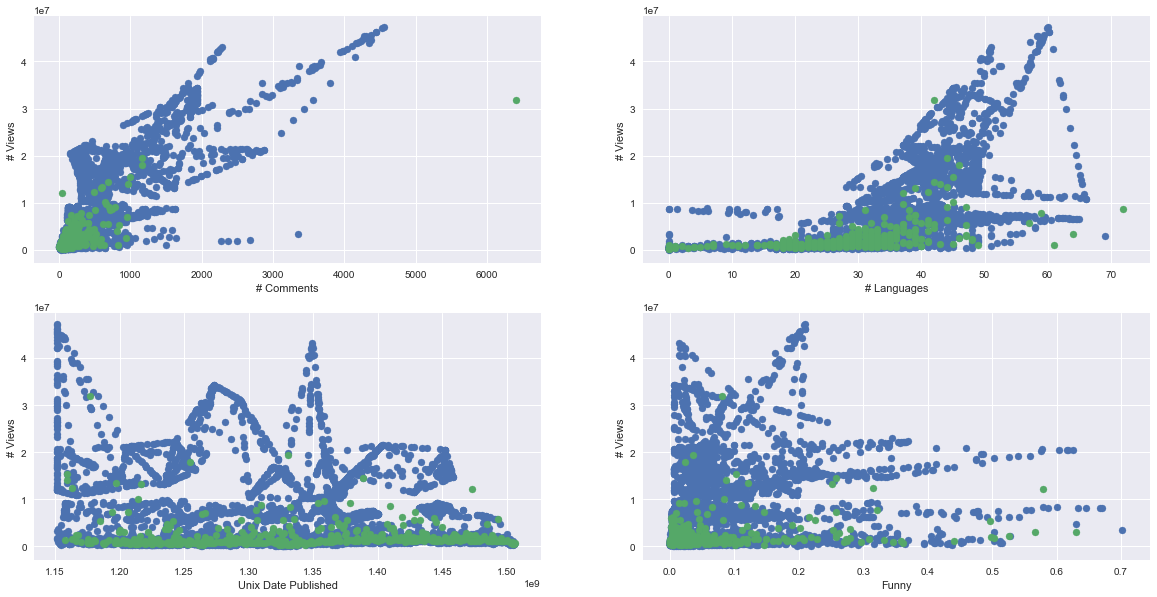

In [221]:
plt.figure(figsize=(20,10))
plt.rcParams.update({'font.size': 18})
# Set up a 2x2 grid so we can look at 4 plots at once
plt.subplot(2, 2, 1)

plt.scatter(X_train['comments'], y_train);
plt.scatter(X_test['comments'], y_pred);
plt.xlabel('# Comments');
plt.ylabel('# Views');

plt.subplot(2, 2, 2)
plt.scatter(X_train['languages'], y_train);
plt.scatter(X_test['languages'], y_pred);
plt.xlabel('# Languages');
plt.ylabel('# Views');

plt.subplot(2, 2, 3)
plt.scatter(X_train['published_date'], y_train);
plt.scatter(X_test['published_date'], y_pred);
plt.xlabel('Unix Date Published');
plt.ylabel('# Views');

plt.subplot(2, 2, 4)
plt.scatter(X_train['Funny'], y_train);
plt.scatter(X_test['Funny'], y_pred);
plt.xlabel('Funny');
plt.ylabel('# Views');

In [226]:
mse_random_forest_all

3538995293458.7183

In [227]:
mse_before_oversample = 2103119145192.1746
#taken from previous notebook

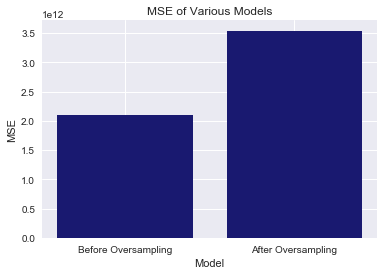

In [228]:
#compare with graph
x_axis = [1,2]
MSE = [mse_before_oversample, mse_random_forest_all]
LABELS = ['Before Oversampling', 'After Oversampling']

plt.bar(x_axis, MSE, align='center', color = 'midnightblue');
plt.xticks(x_axis, LABELS);
plt.title('MSE of Various Models');
plt.xlabel('Random Forest Model');
plt.ylabel('MSE');